# Importing libraries  

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Task1 

# Problem Statement

The client wants to use machine learning to classify text paragraphs into one of five categories: "artificial intelligence", "movies about artificial intelligence", "programming", "philosophy", and "biographies", using "paragraph" and "has_entity" as input features. The goal is to outperform a trivial baseline, avoid overfitting, and ensure no more than 10% of paragraphs are misclassified into unrelated categories, with some tolerance for confusion between "artificial intelligence" and "programming". They also seek advice on the best scalar performance metric to evaluate the model's effectiveness.

## Data loading

In [163]:
data = pd.read_csv("comp1804_coursework_dataset_23-24.csv")
data.head(15)


par_id                                          paragraph  \
0   428209002237  Ramsay was born in Glasgow on 2 October 1852. ...   
1   564218010072  It has been widely estimated for at least the ...   
2   291401001672  He went on to win the Royal Medal of the Royal...   
3    31548004883  The changes have altered many underlying assum...   
4    50634005146  After these novels were published, Disraeli de...   
5   220520007895  Philo also proposes that the order in nature m...   
6     6360003753   This led to the AI spring of the early 2020s,...   
7   848119011941  A second form of functionalism is based on the...   
8    49279000639  The opposite of "moral" is "immoral", meaning ...   
9    79225005859  Pepys' diary provides a first-hand account of ...   
10  959908012329  Looking ahead, the current progress in data-to...   
11  123020006718  Real-time programs such as simulations, flight...   
12  113961006578  Darwin was the inventor of several devices, th...   
13    8471004175   He was among the first British troops into bo...   
14  657766010751  In 1834, Friedlieb Ferdinand Runge discovered ...   

                         has_entity  lexicon_count  difficult_words  \
0    ORG_YES_PRODUCT_NO_PERSON_YES_             49             12.0   
1     ORG_YES_PRODUCT_NO_PERSON_NO_            166             47.0   
2     ORG_YES_PRODUCT_NO_PERSON_NO_             69             18.0   
3     ORG_NO_PRODUCT_YES_PERSON_NO_             76             27.0   
4   ORG_YES_PRODUCT_YES_PERSON_YES_            200             47.0   
5      ORG_NO_PRODUCT_NO_PERSON_NO_            137             36.0   
6     ORG_YES_PRODUCT_NO_PERSON_NO_            116             47.0   
7    ORG_YES_PRODUCT_NO_PERSON_YES_             42             14.0   
8      ORG_NO_PRODUCT_NO_PERSON_NO_             51              8.0   
9    ORG_NO_PRODUCT_YES_PERSON_YES_            139             31.0   
10     ORG_NO_PRODUCT_NO_PERSON_NO_             70             22.0   
11     ORG_NO_PRODUCT_NO_PERSON_NO_             84             38.0   
12    ORG_NO_PRODUCT_NO_PERSON_YES_             35              8.0   
13   ORG_YES_PRODUCT_NO_PERSON_YES_            214             46.0   
14   ORG_YES_PRODUCT_NO_PERSON_YES_            136             37.0   

   last_editor_gender                 category      text_clarity  
0                 man              biographies      clear_enough  
1                 man  artificial intelligence  not_clear_enough  
2          non-binary              biographies      clear_enough  
3          non-binary              programming      clear_enough  
4                 man              biographies  not_clear_enough  
5                 man               philosophy  not_clear_enough  
6                 man  artificial intelligence      clear_enough  
7                 man               philosophy  not_clear_enough  
8                 man               philosophy      clear_enough  
9                 man              biographies      clear_enough  
10              woman  artificial intelligence      clear_enough  
11                man              programming      clear_enough  
12              woman              biographies      clear_enough  
13                man              biographies      clear_enough  
14              woman              biographies      clear_enough

# Data understanding

# Removing Null Values

In [164]:
print(data.isna().sum())

par_id                 0
paragraph              0
has_entity             0
lexicon_count          0
difficult_words       18
last_editor_gender     0
category              61
text_clarity           0
dtype: int64


In [165]:
print(data.shape)

(9347, 8)


In [166]:
print(data.dtypes)

par_id                  int64
paragraph              object
has_entity             object
lexicon_count           int64
difficult_words       float64
last_editor_gender     object
category               object
text_clarity           object
dtype: object


In [167]:
data.category.unique()

array(['biographies', 'artificial intelligence', 'programming',
       'philosophy', 'movies about artificial intelligence', 'Philosophy',
       nan, 'Programming', 'Artificial intelligence', 'Biographies',
       'Movies about artificial intelligence'], dtype=object)

# Removing Duplicates

In [168]:
# Drop duplicate rows based on the 'paragraph' column
data = data.drop_duplicates(subset='paragraph')

# Optional: Check the shape of the DataFrame after dropping duplicates
print(data.shape)


(8992, 8)


# Normalizing class labels

In [169]:
def normalize_class_labels(data):
    # Normalize Unicode strings to a standard form (NFKD)
    data = data.apply(lambda x: unicodedata.normalize('NFKD', x))
    # Convert to lowercase
    data = data.str.lower()
    # Remove new line characters
    data = data.str.replace('\n', '', regex=False)
    # Replace non-ASCII characters with their closest ASCII equivalent or remove them
    data = data.apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
    return data

def normalize_category_labels(data):
    data = data.str.lower()  # Convert to lowercase
    return data

data['paragraph_normalized'] = normalize_class_labels(data['paragraph'])
data['category'] = normalize_category_labels(data['category'])
data.shape


(8992, 9)

In [170]:
print(data.shape)

(8992, 9)


# Data preparation

In [171]:
data = data.dropna(subset=['category'])
X = data['paragraph']  
y = data['category'].str.lower() 

# Label Encoder

In [172]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

array([1, 0, 1, ..., 1, 4, 3])

In [173]:
data.dtypes

par_id                    int64
paragraph                object
has_entity               object
lexicon_count             int64
difficult_words         float64
last_editor_gender       object
category                 object
text_clarity             object
paragraph_normalized     object
dtype: object

# Model building

In [174]:
X = data['paragraph']  
y = data['category'].str.lower() 
X

0       Ramsay was born in Glasgow on 2 October 1852. ...
1       It has been widely estimated for at least the ...
2       He went on to win the Royal Medal of the Royal...
3       The changes have altered many underlying assum...
4       After these novels were published, Disraeli de...
                              ...                        
9342    Sir Joseph Dalton Hooker  was a British botani...
9343    As successful invasions of India generally cam...
9344    Hawking was born on 8 January 1942 in Oxford t...
9345    More complex tasks can be making custom data e...
9346    Governments, and especially the police and cou...
Name: paragraph, Length: 8966, dtype: object

# train_test_split data

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7172,) (7172,)
(1794,) (1794,)


In [177]:
X_train.shape

(7172,)

# Category distribution analysis and missing values

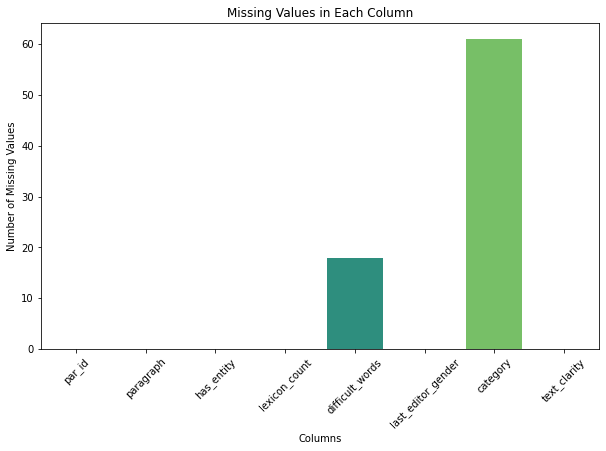

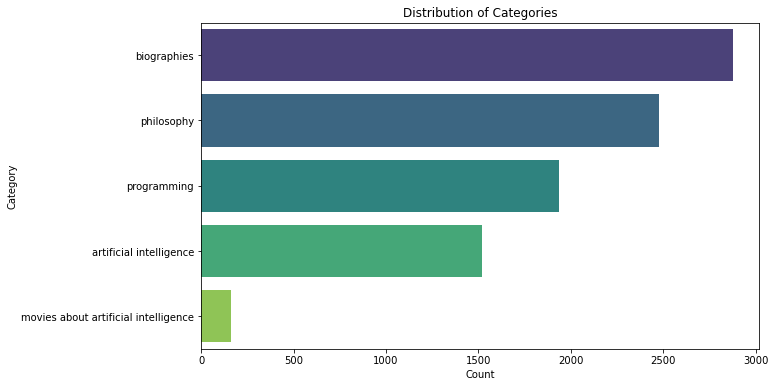

In [178]:

categories = data['category'].unique()[:5]

data = data[data['category'].isin(categories)]

# Plotting

# Plotting missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.title('Missing Values in Each Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()

# Plotting the first 5 unique categories
plt.figure(figsize=(10, 6))
sns.countplot(y=data['category'], palette='viridis', order=data['category'].value_counts().index)
plt.title('Distribution of Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()



# Model training

# Feature Extraction

In [179]:
# Initialize the TfidfVectorizer with the same max_features parameter
tfidf_vectorizer = TfidfVectorizer(max_features=7000)

# Fit the vectorizer on the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Model training
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

# Model Initialization

The code constructs various classifiers, each utilizing different machine learning techniques, and trains them on a given dataset. It generates predictions for both the training and test datasets. Evaluation metrics such as accuracy, precision, recall, and F1-score are calculated for each classifier. These results are organized and stored in a structured dictionary. The performance metrics are then converted into a DataFrame for thorough analysis and visualization, allowing researchers to compare and select the most suitable model for the task.

# Model Evaluation

# SVM Classifier

In [180]:
y_pred = svm_classifier.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9286510590858417

Classification Report:
                                       precision    recall  f1-score   support

             artificial intelligence       0.90      0.89      0.89       309
                         biographies       0.95      0.94      0.94       573
movies about artificial intelligence       1.00      0.91      0.95        34
                          philosophy       0.90      0.94      0.92       485
                         programming       0.96      0.93      0.95       393

                            accuracy                           0.93      1794
                           macro avg       0.94      0.92      0.93      1794
                        weighted avg       0.93      0.93      0.93      1794



# Hyper-parameter tuning 

In [181]:
# SVM Classifier with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1],
    'kernel': ['linear', 'rbf']
}
svm_classifier = SVC()
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train_tfidf, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predictions using the best estimator
best_svm_classifier = grid_search.best_estimator_
y_pred = best_svm_classifier.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best Score: 0.9280526195578751
Accuracy: 0.9286510590858417

Classification Report:
                                       precision    recall  f1-score   support

             artificial intelligence       0.92      0.86      0.89       309
                         biographies       0.94      0.95      0.94       573
movies about artificial intelligence       1.00      0.79      0.89        34
                          philosophy       0.88      0.95      0.91       485
                         programming       0.97      0.94      0.96       393

                            accuracy                           0.93      1794
                           macro avg       0.94      0.90      0.92      1794
                        weighted avg       0.93      0.93      0.93      1794



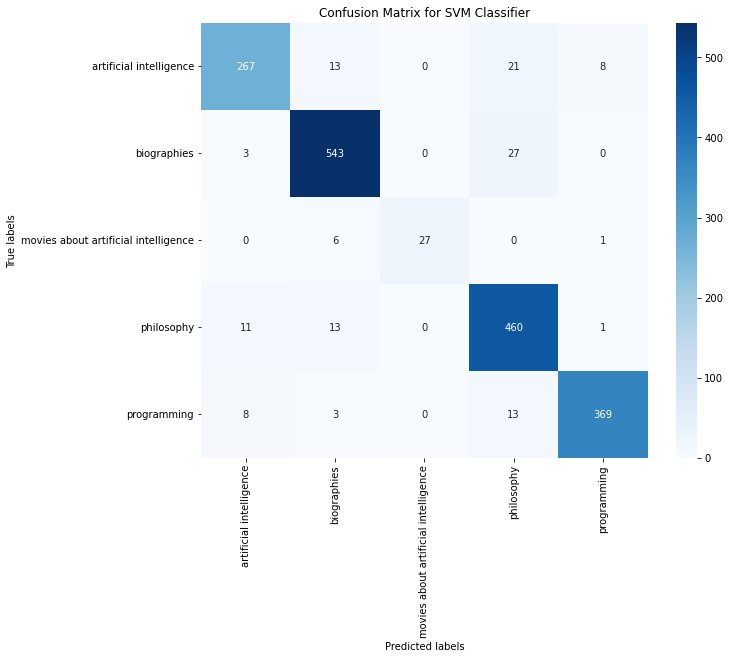

In [182]:

# Predictions using the best estimator
y_pred = best_svm_classifier.predict(X_test_tfidf)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=best_svm_classifier.classes_, yticklabels=best_svm_classifier.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for SVM Classifier')
plt.show()


# Classifiers Evaluation

# Random forest

In [183]:
# Classifiers
classifiers = {
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    print(f"Training random forest")
    classifier.fit(X_train_tfidf, y_train)
    y_pred = classifier.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Accuracy for random forest: {accuracy}")
    print(f"Classification Report for random forest:\n{report}\n")

Training random forest
Accuracy for random forest: 0.81438127090301
Classification Report for random forest:
                                      precision    recall  f1-score   support

             artificial intelligence       0.89      0.60      0.72       309
                         biographies       0.84      0.89      0.86       573
movies about artificial intelligence       1.00      0.29      0.45        34
                          philosophy       0.73      0.87      0.79       485
                         programming       0.86      0.85      0.85       393

                            accuracy                           0.81      1794
                           macro avg       0.86      0.70      0.74      1794
                        weighted avg       0.83      0.81      0.81      1794




In [186]:
# Hyperparameters for GridSearchCV
param_grids = {
    "Random Forest": {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
}

# Perform GridSearchCV for each classifier
for name, classifier in classifiers.items():
    print(f"GridSearchCV for random forest...")
    param_grid = param_grids[name]
    grid_search = GridSearchCV(classifier, param_grid, cv=5, n_jobs=-1, verbose=3)
    grid_search.fit(X_train_tfidf, y_train)
    
    # Best parameters and best score
    print(f"Best Parameters for random forest: {grid_search.best_params_}")
    print(f"Best Score for random forest: {grid_search.best_score_}")

    # Predictions using the best estimator
    best_classifier = grid_search.best_estimator_
    y_pred = best_classifier.predict(X_test_tfidf)

    # Evaluation
    print(f"Accuracy for random forest: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report for random forest:\n{classification_report(y_test, y_pred)}\n")

GridSearchCV for random forest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for random forest: {'max_depth': None, 'n_estimators': 300}
Best Score for random forest: 0.8159498296716379
Accuracy for random forest: 0.8154960981047937
Classification Report for random forest:
                                      precision    recall  f1-score   support

             artificial intelligence       0.91      0.59      0.71       309
                         biographies       0.83      0.88      0.85       573
movies about artificial intelligence       1.00      0.21      0.34        34
                          philosophy       0.74      0.86      0.79       485
                         programming       0.86      0.89      0.88       393

                            accuracy                           0.82      1794
                           macro avg       0.87      0.69      0.72      1794
                        weighted avg       0.83      0.82      0.81

Training random forest...


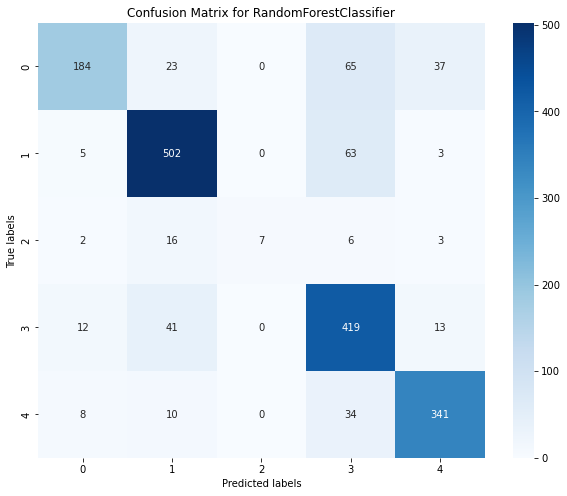

In [189]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for RandomForestClassifier')
    plt.show()

# Classifiers
classifiers = {
    "Random Forest": RandomForestClassifier()
}

# Train each classifier and plot the confusion matrix
for name, classifier in classifiers.items():
    print(f"Training random forest...")
    classifier.fit(X_train_tfidf, y_train)
    y_pred = classifier.predict(X_test_tfidf)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, RandomForestClassifier)




# MultinomialNB

In [190]:

classifiers = {
    "Multinomial Naive Bayes": MultinomialNB()
}

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    print(f"Training {name}...")
    classifier.fit(X_train_tfidf, y_train)
    y_pred = classifier.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy}")
    print(f"Classification Report for {name}:\n{report}\n")

Training Multinomial Naive Bayes...
Accuracy for Multinomial Naive Bayes: 0.89520624303233
Classification Report for Multinomial Naive Bayes:
                                      precision    recall  f1-score   support

             artificial intelligence       0.92      0.80      0.86       309
                         biographies       0.91      0.91      0.91       573
movies about artificial intelligence       1.00      0.09      0.16        34
                          philosophy       0.83      0.95      0.88       485
                         programming       0.94      0.96      0.95       393

                            accuracy                           0.90      1794
                           macro avg       0.92      0.74      0.75      1794
                        weighted avg       0.90      0.90      0.89      1794




In [192]:
# Hyperparameters for GridSearchCV
param_grids = {
    "Multinomial Naive Bayes": {'alpha': [0.1, 0.5, 1.0]}
}

# Perform GridSearchCV for each classifier
for name, classifier in classifiers.items():
    print(f"GridSearchCV for MultinomialNB...")
    param_grid = param_grids[name]
    grid_search = GridSearchCV(classifier, param_grid, cv=5, n_jobs=-1, verbose=3)
    grid_search.fit(X_train_tfidf, y_train)
    
    # Best parameters and best score
    print(f"Best Parameters for MultinomialNB: {grid_search.best_params_}")
    print(f"Best Score for MultinomialNB: {grid_search.best_score_}")

    # Predictions using the best estimator
    best_classifier = grid_search.best_estimator_
    y_pred = best_classifier.predict(X_test_tfidf)

    # Evaluation
    print(f"Accuracy for MultinomialNB: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report for MultinomialNB:\n{classification_report(y_test, y_pred)}\n")

GridSearchCV for MultinomialNB...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters for MultinomialNB: {'alpha': 0.1}
Best Score for MultinomialNB: 0.9256811433625394
Accuracy for MultinomialNB: 0.9236343366778149
Classification Report for MultinomialNB:
                                      precision    recall  f1-score   support

             artificial intelligence       0.89      0.88      0.89       309
                         biographies       0.95      0.91      0.93       573
movies about artificial intelligence       1.00      0.94      0.97        34
                          philosophy       0.88      0.94      0.91       485
                         programming       0.97      0.96      0.96       393

                            accuracy                           0.92      1794
                           macro avg       0.94      0.93      0.93      1794
                        weighted avg       0.92      0.92      0.92      1794




Training MultinomialNB...


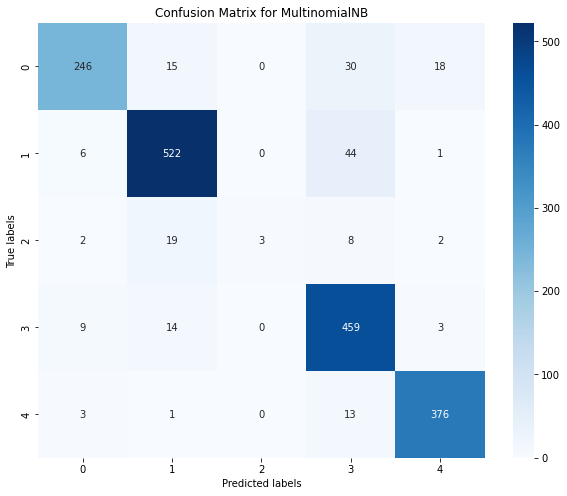

In [193]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for MultinomialNB')
    plt.show()

# Classifiers
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB()
} 

# Train each classifier and plot the confusion matrix
for name, classifier in classifiers.items():
    print(f"Training MultinomialNB...")
    classifier.fit(X_train_tfidf, y_train)
    y_pred = classifier.predict(X_test_tfidf)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred,MultinomialNB)


# Decision Tree

In [194]:
classifiers = {
  "Decision Tree": DecisionTreeClassifier()
}

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    print(f"Training DecisionTreeClassifier...")
    classifier.fit(X_train_tfidf, y_train)
    y_pred = classifier.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Accuracy for DecisionTreeClassifier: {accuracy}")
    print(f"Classification Report for DecisionTreeClassifier:\n{report}\n")

Training DecisionTreeClassifier...
Accuracy for DecisionTreeClassifier: 0.664994425863991
Classification Report for DecisionTreeClassifier:
                                      precision    recall  f1-score   support

             artificial intelligence       0.53      0.52      0.53       309
                         biographies       0.80      0.77      0.79       573
movies about artificial intelligence       0.58      0.41      0.48        34
                          philosophy       0.58      0.67      0.62       485
                         programming       0.71      0.64      0.68       393

                            accuracy                           0.66      1794
                           macro avg       0.64      0.60      0.62      1794
                        weighted avg       0.67      0.66      0.67      1794




In [195]:
# Hyperparameters for GridSearchCV
param_grids = {
    "Decision Tree": {'max_depth': [None, 10, 20, 30]}
}

# Perform GridSearchCV for each classifier
for DecisionTreeClassifier, classifier in classifiers.items():
    print(f"GridSearchCV for DecisionTreeClassifier...")
    param_grid = param_grids[name]
    grid_search = GridSearchCV(classifier, param_grid, cv=5, n_jobs=-1, verbose=3)
    grid_search.fit(X_train_tfidf, y_train)
    
    # Best parameters and best score
    print(f"Best Parameters for DecisionTreeClassifier: {grid_search.best_params_}")
    print(f"Best Score for DecisionTreeClassifier: {grid_search.best_score_}")

    # Predictions using the best estimator
    best_classifier = grid_search.best_estimator_
    y_pred = best_classifier.predict(X_test_tfidf)

    # Evaluation
    print(f"Accuracy for DecisionTreeClassifier: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report for DecisionTreeClassifier:\n{classification_report(y_test, y_pred)}\n")

GridSearchCV for DecisionTreeClassifier...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters for DecisionTreeClassifier: {'max_depth': 30}
Best Score for DecisionTreeClassifier: 0.6475154413229727
Accuracy for DecisionTreeClassifier: 0.664994425863991
Classification Report for DecisionTreeClassifier:
                                      precision    recall  f1-score   support

             artificial intelligence       0.54      0.51      0.53       309
                         biographies       0.74      0.80      0.77       573
movies about artificial intelligence       0.75      0.44      0.56        34
                          philosophy       0.60      0.66      0.62       485
                         programming       0.74      0.61      0.67       393

                            accuracy                           0.66      1794
                           macro avg       0.67      0.61      0.63      1794
                        weighted avg       0.6

Training Decision Tree...


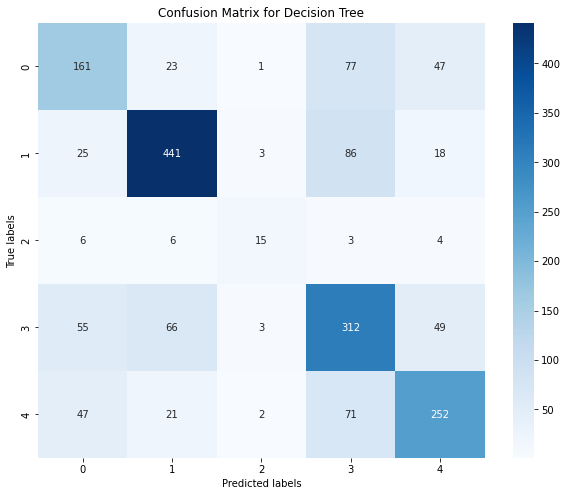

In [201]:


# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

# Classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier()
}

# Train each classifier and plot the confusion matrix
for name, classifier in classifiers.items():
    print(f"Training {name}...")
    classifier.fit(X_train_tfidf, y_train)
    y_pred = classifier.predict(X_test_tfidf)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, f'Confusion Matrix for {name}')



# Gradient Boosting

In [202]:
classifiers = {
 "Gradient Boosting": GradientBoostingClassifier()
}

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    print(f"Training GradientBoostingClassifier...")
    classifier.fit(X_train_tfidf, y_train)
    y_pred = classifier.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Accuracy for GradientBoostingClassifier: {accuracy}")
    print(f"Classification Report for GradientBoostingClassifier:\n{report}\n")

Training GradientBoostingClassifier...
Accuracy for GradientBoostingClassifier: 0.8394648829431438
Classification Report for GradientBoostingClassifier:
                                      precision    recall  f1-score   support

             artificial intelligence       0.89      0.72      0.80       309
                         biographies       0.88      0.86      0.87       573
movies about artificial intelligence       0.81      0.76      0.79        34
                          philosophy       0.73      0.88      0.80       485
                         programming       0.91      0.85      0.88       393

                            accuracy                           0.84      1794
                           macro avg       0.85      0.82      0.83      1794
                        weighted avg       0.85      0.84      0.84      1794




In [204]:
# Hyperparameters for GridSearchCV
param_grids = {
    "Gradient Boosting": {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.05, 0.01]}
}

# Perform GridSearchCV for each classifier
for name, classifier in classifiers.items():
    print(f"GridSearchCV for GradientBoostingClassifier...")
    param_grid = param_grids[name]
    grid_search = GridSearchCV(classifier, param_grid, cv=5, n_jobs=-1, verbose=3)
    grid_search.fit(X_train_tfidf, y_train)
    
    # Best parameters and best score
    print(f"Best Parameters for GradientBoostingClassifier: {grid_search.best_params_}")
    print(f"Best Score for GradientBoostingClassifier: {grid_search.best_score_}")

    # Predictions using the best estimator
    best_classifier = grid_search.best_estimator_
    y_pred = best_classifier.predict(X_test_tfidf)

    # Evaluation
    print(f"Accuracy for GradientBoostingClassifier: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report for GradientBoostingClassifier:\n{classification_report(y_test, y_pred)}\n")

GridSearchCV for GradientBoostingClassifier...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for GradientBoostingClassifier: {'learning_rate': 0.1, 'n_estimators': 200}
Best Score for GradientBoostingClassifier: 0.8650299593252957
Accuracy for GradientBoostingClassifier: 0.8662207357859532
Classification Report for GradientBoostingClassifier:
                                      precision    recall  f1-score   support

             artificial intelligence       0.90      0.78      0.83       309
                         biographies       0.90      0.88      0.89       573
movies about artificial intelligence       0.85      0.82      0.84        34
                          philosophy       0.77      0.90      0.83       485
                         programming       0.93      0.88      0.90       393

                            accuracy                           0.87      1794
                           macro avg       0.87      0.85      0.86      1794

Training GradientBoostingClassifier...


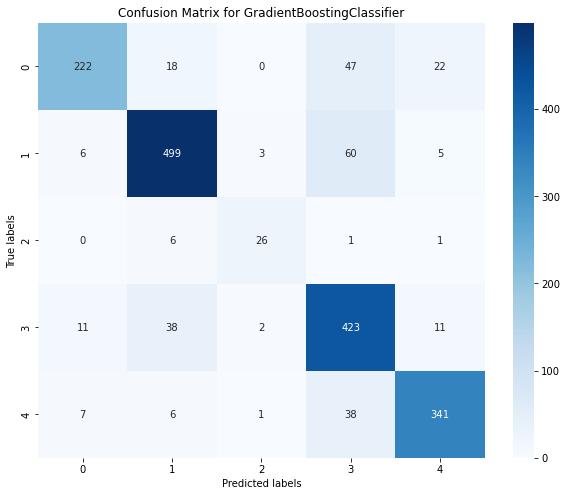

In [205]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for GradientBoostingClassifier')
    plt.show()

# Classifiers
classifiers = {
    "Gradient Boosting": GradientBoostingClassifier()
}

# Train each classifier and plot the confusion matrix
for name, classifier in classifiers.items():
    print(f"Training GradientBoostingClassifier...")
    classifier.fit(X_train_tfidf, y_train)
    y_pred = classifier.predict(X_test_tfidf)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, GradientBoostingClassifier)




# Comparison with trivial baseline

In [28]:

# Evaluate a trivial baseline (e.g., random guessing or majority class)
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train_tfidf, y_train)
dummy_pred = dummy_clf.predict(X_test_tfidf)

# Trivial baseline performance
print("\nTrivial Baseline (Dummy Classifier):")
print("Accuracy:", accuracy_score(y_test, dummy_pred))
print("\nClassification Report:")
print(classification_report(y_test, dummy_pred))





Trivial Baseline (Dummy Classifier):
Accuracy: 0.26695371367061355

Classification Report:
                                      precision    recall  f1-score   support

             artificial intelligence       0.20      0.21      0.20       305
                         biographies       0.34      0.32      0.33       622
movies about artificial intelligence       0.03      0.03      0.03        30
                          philosophy       0.27      0.29      0.28       500
                         programming       0.22      0.22      0.22       401

                            accuracy                           0.27      1858
                           macro avg       0.21      0.21      0.21      1858
                        weighted avg       0.27      0.27      0.27      1858



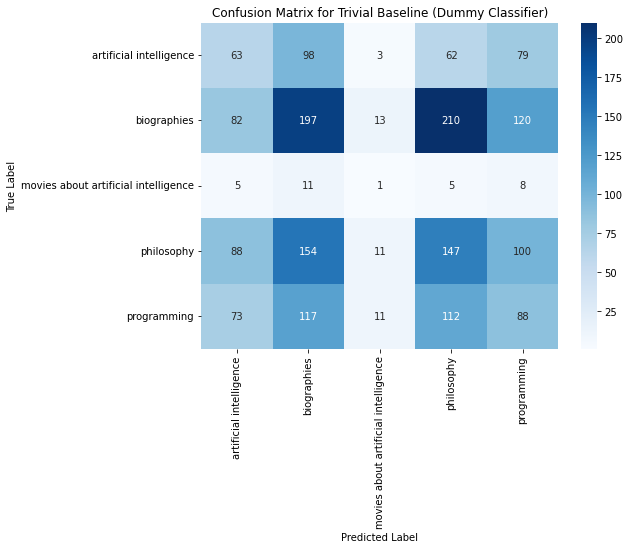

In [29]:


# Compute confusion matrix for Dummy Classifier
conf_matrix_dummy = confusion_matrix(y_test, dummy_pred)

# Plot confusion matrix for Dummy Classifier
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dummy, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Trivial Baseline (Dummy Classifier)')
plt.show()


# Task 2

Design a machine learning prototype to determine if a given paragraph is sufficiently clear for inclusion in a knowledge base. Begin by manually labeling a subset of the dataset and then train the model to predict these labels using relevant text features. The labels should categorize text clarity into "clear_enough" and "not_clear_enough".

In [245]:
unlabeled_data = pd.read_csv("comp1804_coursework_dataset_23-24.csv")

In [246]:
unlabeled_data.head(5)

par_id                                          paragraph  \
0  428209002237  Ramsay was born in Glasgow on 2 October 1852. ...   
1  564218010072  It has been widely estimated for at least the ...   
2  291401001672  He went on to win the Royal Medal of the Royal...   
3   31548004883  The changes have altered many underlying assum...   
4   50634005146  After these novels were published, Disraeli de...   

                        has_entity  lexicon_count  difficult_words  \
0   ORG_YES_PRODUCT_NO_PERSON_YES_             49             12.0   
1    ORG_YES_PRODUCT_NO_PERSON_NO_            166             47.0   
2    ORG_YES_PRODUCT_NO_PERSON_NO_             69             18.0   
3    ORG_NO_PRODUCT_YES_PERSON_NO_             76             27.0   
4  ORG_YES_PRODUCT_YES_PERSON_YES_            200             47.0   

  last_editor_gender                 category      text_clarity  
0                man              biographies      clear_enough  
1                man  artificial intelligence  not_clear_enough  
2         non-binary              biographies      clear_enough  
3         non-binary              programming      clear_enough  
4                man              biographies  not_clear_enough

In [247]:
labeled_data = pd.read_excel("labelled.xlsx")

In [248]:
labeled_data.head(5)

par_id                                          paragraph  \
0  848000000000  A second form of functionalism is based on the...   
1  428000000000  Ramsay was born in Glasgow on 2 October 1852. ...   
2   49279000639  The opposite of "moral" is "immoral", meaning ...   
3  291000000000  He went on to win the Royal Medal of the Royal...   
4   31548004883  The changes have altered many underlying assum...   

                       has_entity  lexicon_count  difficult_words  \
0  ORG_YES_PRODUCT_NO_PERSON_YES_             42               14   
1  ORG_YES_PRODUCT_NO_PERSON_YES_             49               12   
2    ORG_NO_PRODUCT_NO_PERSON_NO_             51                8   
3   ORG_YES_PRODUCT_NO_PERSON_NO_             69               18   
4   ORG_NO_PRODUCT_YES_PERSON_NO_             76               27   

  last_editor_gender     category      text_clarity  
0                man   philosophy  not_clear_enough  
1                man  biographies      clear_enough  
2                man   philosophy      clear_enough  
3         non-binary  biographies      clear_enough  
4         non-binary  programming      clear_enough

In [249]:
labeled_data.text_clarity.value_counts()

not_clear_enough    77
clear_enough        72
Name: text_clarity, dtype: int64

In [250]:
# Assuming both DataFrames have a column 'paragraph' for matching
data_without_labels = unlabeled_data[~unlabeled_data['paragraph'].isin(labeled_data['paragraph'])]

# Display the shape of the filtered DataFrame
print("Shape of data without labels:", data_without_labels.shape)


Shape of data without labels: (9232, 8)


In [251]:
# Assuming 'unlabeled_data' DataFrame includes the predicted labels
# Load the dataset
unlabeled_data = pd.read_csv("unlabeled_dataset_with_predictions.csv")

# Count the occurrences of each predicted label
label_counts = unlabeled_data['predicted_label'].value_counts()



In [252]:
# Assuming you have a DataFrame called 'data' with 150 data points
data = pd.read_excel("labelled.xlsx")  

X = data['paragraph']
y = data['text_clarity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the sizes of the training and testing sets
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 119
Testing set size: 30


# SVM Classifier

In [253]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model training
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)


SVC(kernel='linear')

In [254]:
y_pred = svm_classifier.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8666666666666667

Classification Report:
                   precision    recall  f1-score   support

    clear_enough       0.83      1.00      0.90        19
not_clear_enough       1.00      0.64      0.78        11

        accuracy                           0.87        30
       macro avg       0.91      0.82      0.84        30
    weighted avg       0.89      0.87      0.86        30



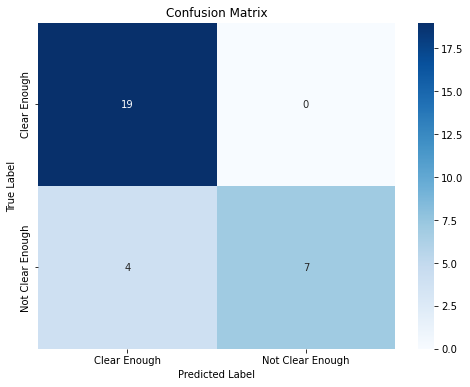

In [255]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Define class labels
class_labels = ["Clear Enough", "Not Clear Enough"]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# Comparison with trivial baseline

In [256]:
# Trivial Baseline with Dummy Classifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train_tfidf, y_train)
dummy_pred = dummy_clf.predict(X_test_tfidf)

# Trivial Baseline Performance
print("\nTrivial Baseline (Dummy Classifier):")
print("Accuracy:", accuracy_score(y_test, dummy_pred))
print("\nClassification Report:")
print(classification_report(y_test, dummy_pred))




Trivial Baseline (Dummy Classifier):
Accuracy: 0.4

Classification Report:
                  precision    recall  f1-score   support

    clear_enough       0.56      0.26      0.36        19
not_clear_enough       0.33      0.64      0.44        11

        accuracy                           0.40        30
       macro avg       0.44      0.45      0.40        30
    weighted avg       0.47      0.40      0.39        30



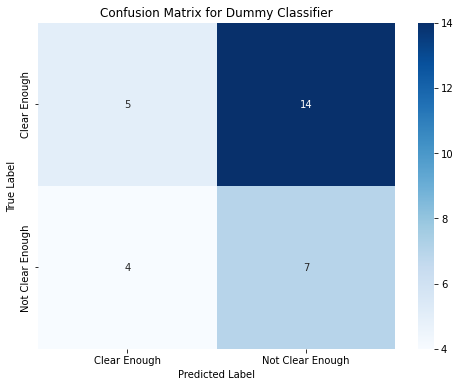

In [257]:
# Confusion Matrix for Dummy Classifier
dummy_conf_matrix = confusion_matrix(y_test, dummy_pred)
class_labels = ["Clear Enough", "Not Clear Enough"]

# Create a heatmap for the dummy classifier confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(dummy_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Dummy Classifier')
plt.show()

# Final Output file

In [258]:
X_unlabeled = unlabeled_data['paragraph']
classifier = load('trained_model.joblib')  
# Make predictions
predicted_labels = classifier.predict(X_unlabeled)

# Add the predicted labels to the unlabeled dataset
unlabeled_data['predicted_label'] = predicted_labels

# Save the updated dataset with predicted labels
unlabeled_data.to_csv("unlabeled_dataset_with_predictions.csv", index=False)


# Predicted data visualisation

In [259]:
# Count the occurrences of each predicted label
label_counts = unlabeled_data['predicted_label'].value_counts()

# Display the counts
print("Predicted Label Counts:")
print(label_counts)


Predicted Label Counts:
clear_enough        7811
not_clear_enough    1536
Name: predicted_label, dtype: int64


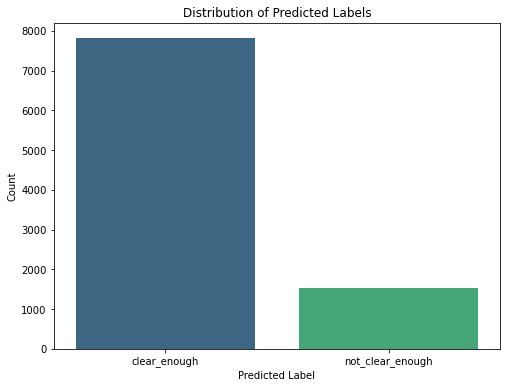

In [260]:
# Create a bar plot for the predicted label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.show()